In [1]:
## Notebook env: brian_script_env (R kernel)

In [2]:
library(ggplot2)
library(scales)
library(parallel)
library(cvequality)
library(readxl)
library(tibble)
library(pbapply)
library(qvalue)
library(gplots)
library(stats)
library(reshape2)
library(gridExtra)
library(tidyverse)


path2 = '/khayyam/ssobti/projects/heterogeneity_brian/output_data/TCGA_nb_analysis/nb_pause_points/TCGA_breast_q10_q90_original_luminalA/'


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tidyr   1.1.3     ✔ dplyr   1.0.6
✔ readr   1.4.0     ✔ stringr 1.4.0
✔ purrr   0.3.4     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ dplyr::combine()    masks gridExtra::combine()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()



In [3]:
## load patient metadata
meta = read.csv('/khayyam/ssobti/projects/heterogeneity_brian/uploaded_data/brca_tcga/data_bcr_clinical_data_patient.txt', skip = 4, sep='\t')

## classify patients into subtypes
meta_luminal_A = meta %>% filter(ER_STATUS_BY_IHC == 'Positive' | PR_STATUS_BY_IHC == 'Positive', IHC_HER2 == 'Negative')
meta_her2 = meta %>% filter(ER_STATUS_BY_IHC == 'Negative', PR_STATUS_BY_IHC == 'Negative', IHC_HER2 == 'Positive')
meta_tnbc = meta %>% filter(ER_STATUS_BY_IHC == 'Negative', PR_STATUS_BY_IHC == 'Negative', IHC_HER2 == 'Negative')
meta_luminal_B_her2 = meta %>% filter(ER_STATUS_BY_IHC == 'Positive', PR_STATUS_BY_IHC == 'Positive', IHC_HER2 == 'Positive')

meta_luminal_A$PATIENT_ID = paste0(str_replace_all(meta_luminal_A$PATIENT_ID, '-', '.'), '.01')
meta_her2$PATIENT_ID = paste0(str_replace_all(meta_her2$PATIENT_ID, '-', '.'), '.01')
meta_tnbc$PATIENT_ID = paste0(str_replace_all(meta_tnbc$PATIENT_ID, '-', '.'), '.01')
meta_luminal_B_her2$PATIENT_ID = paste0(str_replace_all(meta_luminal_B_her2$PATIENT_ID, '-', '.'), '.01')

## Get patient subtype counts
paste('Luminal A patients:', nrow(meta_luminal_A))
paste('HER2+ patients:', nrow(meta_her2))
paste('Triple negative patients:', nrow(meta_tnbc))
paste('Luminal B with HER2+ patients:', nrow(meta_luminal_B_her2))

[1] "Luminal A patients: 445"

[1] "HER2+ patients: 37"

[1] "Triple negative patients: 116"

[1] "Luminal B with HER2+ patients: 100"

[1] FALSE

png 
  2

png 
  2

[1] 73.04395

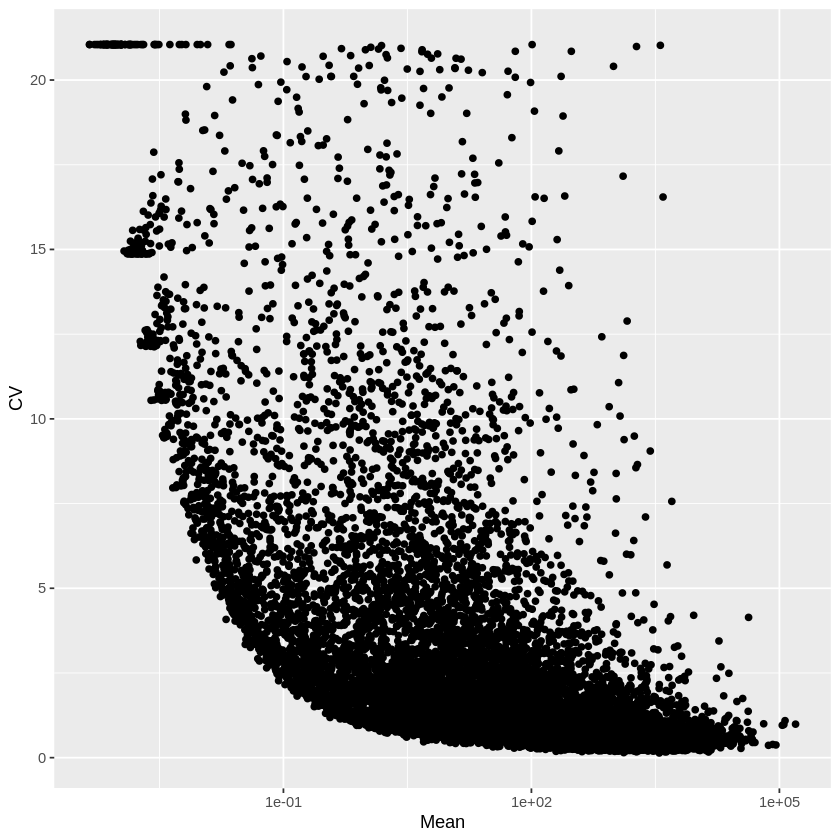

In [4]:
#' ---
#' title: "Analyzing BRCA TCGA data, FPKM data of **medium to high expressing** genes using Brian's script"
#' output: html_notebook
#' ---
#' 
#' This is modified version of Brian's q25 and q75 script: 'Analysis_heterogeneity_BRCA_TCGA_FPKM_approach_q25_q75.Rmd'
#' 
#' Let's create a mean vs CV graph for the patients to create a remove low expressing genes with high variability from our analysis
#' 
## ------------------------------------------------------------------------------



## load in data
RNA_Seq_expression_raw_data <- 
read.delim("/khayyam/ssobti/projects/heterogeneity_brian/uploaded_data/brca_tcga/data_RNA_Seq_v2_expression_median.txt", stringsAsFactors = FALSE)

## subset breast cancer patients by type here
RNA_Seq_expression_raw_data = RNA_Seq_expression_raw_data %>% select(any_of(c('Hugo_Symbol', 'Entrez_Gene_Id', meta_luminal_A$PATIENT_ID))) %>% as.data.frame()

#The 'all' approach to check if all values in a row are 0
check_if_not_zero <- function (vector, number = 0) {
  if (!(all (vector == number))) {
    return (TRUE) #if not zero, then returns TRUE
  }
  else{
    return(FALSE)
  }
}

#See if there are any rows that are FALSE, meaning that are actually all 0
all(as.vector(unlist(apply(RNA_Seq_expression_raw_data[,-1:-2], 1, check_if_not_zero)))) 
zero_genes = as.vector(unlist(apply(RNA_Seq_expression_raw_data[,-1:-2], 1, check_if_not_zero)))

##take out genes with no expression in any of the patients
RNA_Seq_expression_raw_data = RNA_Seq_expression_raw_data[as.vector(unlist(apply(RNA_Seq_expression_raw_data[,-1:-2], 1, check_if_not_zero))),]


gene_medians = apply(RNA_Seq_expression_raw_data[, -c(1,2)], 1, median)

median_df = data.frame(medians = gene_medians)

pdf(paste0(path2, 'gene_expression_pre_filter1.pdf'), height = 8, width = 8)
ggplot(median_df, aes(x=gene_medians)) + 
  geom_histogram(color="black", fill="white", bins = 500) +
  geom_vline(xintercept = 10, color = 'blue') +
  theme_bw()
dev.off()

pdf(paste0(path2, 'gene_expression_pre_filter2.pdf'), height = 8, width = 8)
ggplot(median_df, aes(x=gene_medians)) + 
  geom_histogram(color="black", fill="white", bins = 50000) +
  geom_vline(xintercept = 10, color = 'blue') + coord_cartesian(xlim = c(0,200)) +
  theme_bw()
dev.off()


pct_genes_left = function(median_expression, cutoff){
  pct = 100*length(which(median_expression >= cutoff))/length(median_expression)
  return(pct)
}

pct_genes_left(gene_medians, 10)

gene_means = apply(RNA_Seq_expression_raw_data[, -c(1,2)], 1, mean)
gene_CVs = apply(RNA_Seq_expression_raw_data[, -c(1,2)], 1, function(x){sd(x)/mean(x)})


gene_level_df = data.frame(Gene_name = RNA_Seq_expression_raw_data$Hugo_Symbol, Mean = gene_means, CV = gene_CVs)

ggplot(gene_level_df, aes(Mean, CV)) + geom_point() + scale_x_log10(breaks = log_breaks(5))


[1] 914

[1] 2463

[1] 578

[1] TRUE

[1] TRUE

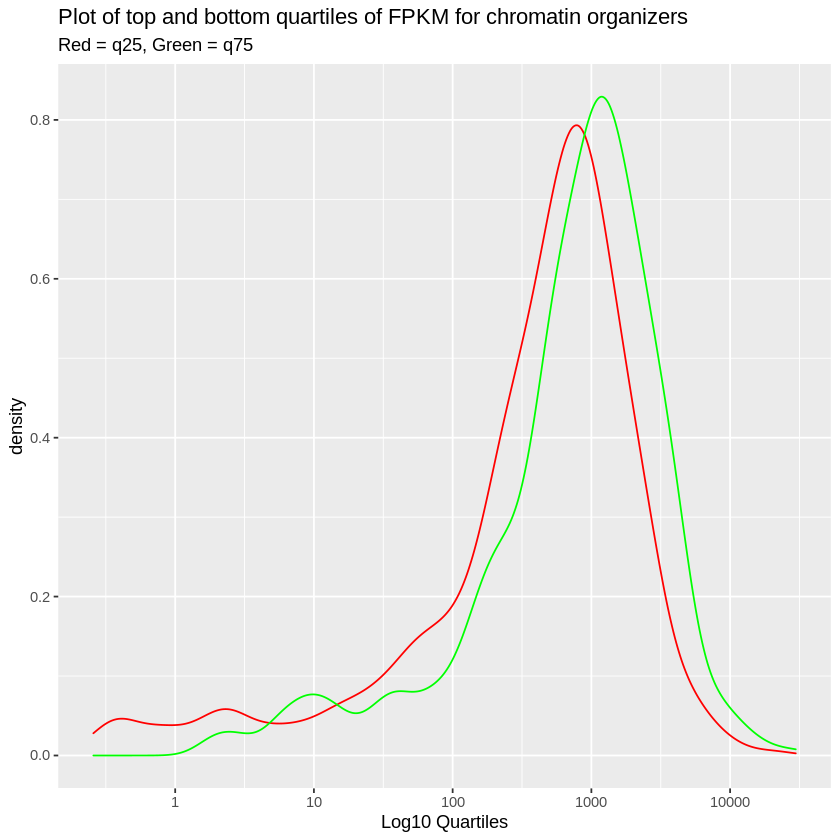

In [5]:
#' Copy and paste Brian's analysis from this point on
## ---- Data loading-------------------------------------------------------------

#Load in chromatin organization modifiers. How this was found: GO term, eukaryota => #mammalia => homo sapiens. Gives a list of gene products; there's non-unique entries #(contributed by different sources, etc)

chromatin_modifiers <- read.delim("/khayyam/ssobti/projects/heterogeneity_brian/uploaded_data/Chromatin_modifiers.txt", header=FALSE, stringsAsFactors=FALSE)

#the first column is the one of interest
colnames(chromatin_modifiers)[1] <- 'Gene Names'

chrom_list_to_sort_against <- unique(chromatin_modifiers$`Gene Names`)

#check lengths of new and original list from chromatin modifiers

length(chrom_list_to_sort_against) 
length(chromatin_modifiers$`Gene Names`)

#logic to extract the chromatin modifier genes specifically from the full RNA Seq list.
#Use the %in% operator to (vector-wise) get the rows specifically. Use this to get
#the quartiles for each gene:

set.seed(42)

chromatin_genes_RNA_seq <- RNA_Seq_expression_raw_data[RNA_Seq_expression_raw_data$Hugo_Symbol %in% chrom_list_to_sort_against,]

#And these are the 'true' groupings. Let's add a column to denote that here, in front
#of the first two columns using the 'add_column' function from tibble library:

chromatin_genes_RNA_seq <- add_column(chromatin_genes_RNA_seq,
                                      Random = 'N', .after = 2)

length(rownames(chromatin_genes_RNA_seq))

#We'd like to also derive a background distribution for all of these genes. To do so,
#let's append 50 genes that are randomly selected from the dataset, and their #corresponding rows. 

random_genes <- sample(RNA_Seq_expression_raw_data$Hugo_Symbol, 50)
random_genes_RNA_seq <- RNA_Seq_expression_raw_data[RNA_Seq_expression_raw_data$Hugo_Symbol %in% random_genes,]

random_names <- random_genes_RNA_seq$Hugo_Symbol

#Let's also add an equivalently named column here to denote that these are the random genes: 

random_genes_RNA_seq <- add_column(random_genes_RNA_seq, Random = 'Y', .after = 2)

full_genes_RNA_seq <- rbind(chromatin_genes_RNA_seq, random_genes_RNA_seq)

length(rownames(full_genes_RNA_seq)) == 
length(rownames(chromatin_genes_RNA_seq)) + length(rownames(random_genes_RNA_seq)) #TRUE

#creating a threshold with which to create 'hi' vs 'lo' populations of patients; here, I #choose to use top vs bottom quartile. Need to apply quantile across the rows of the #chromatin_genes data frame, excluding the first observation (which is a character string #of the gene name in question)

q25 <- apply(full_genes_RNA_seq[,-1:-3], 1, quantile, probs = c(0.25), na.rm = TRUE)

q75 <- apply(full_genes_RNA_seq[,-1:-3], 1, quantile, probs = c(0.75), na.rm = TRUE)


full_genes_RNA_seq <- add_column(full_genes_RNA_seq, q25 = q25, q75 = q75, .after = 3)

all (full_genes_RNA_seq$q25 <= full_genes_RNA_seq$q75) #true

#Also remove data where the bottom quartile is 0 FPKM. This doesn't seem like it would
#provide any meaningful data to a CV comparison.

full_genes_RNA_seq <- 
full_genes_RNA_seq[!(full_genes_RNA_seq$q25 == 0),]

#Viewing the data and indices

ggplot(full_genes_RNA_seq) + geom_density(aes (x = q25), color = 'red') +
geom_density (aes (x = q75), color = 'green') + 
labs (title = 'Plot of top and bottom quartiles of FPKM for chromatin organizers', 
      subtitle = 'Red = q25, Green = q75',
      x = 'Log10 Quartiles') + 
scale_x_log10()

In [6]:
#' ### Getting groupings of the data based on chromatin modifier expression
#' 
#' We've now completed some EDA of the data and cleaning of useless chromatin modifier factors that wouldn't be good for grouping. Now, let's get dataframes corresponding to these groupings in a list format to each unique chromatin modifier, then use these groupings to get subsetted dataframes from the full dataset corresponding to bottom/top expressers of each chromatin modifier.
#' 
## ---- Getting lo/hi groupings--------------------------------------------------

#Now I want lo and hi expressers (below q25, above q75) for each gene. Way to approach #this: create different groupings, based on hi/lo threshold. To first get the groupings #and return #them in a list: define a function that returns up to three entries in list #format. These are: Gene name, all names below the bottom quantile, and all names above #the top quantile.

groupings_returner <- function (gene, chromatin_data, gene_col = 1, random = 3, 
                                q25_col = 4, q75_col = 5) {
  #the q25_col, q75_col are last two columns in the data frame
  q25 = chromatin_data[chromatin_data[,gene_col]==gene, q25_col] 
  q75 = chromatin_data[chromatin_data[,gene_col]==gene, q75_col]
  rand_designation = chromatin_data[chromatin_data[,gene_col]==gene, random] 
  #get the q25, q75 'indices'
  row = chromatin_data[chromatin_data[,gene_col]==gene, c(-1:-2, -random, 
                                                          -q25_col, -q75_col)]
  #eliminate gene ID, the q25 and q75 columns; isolate a single row
  col = data.frame(t(row)) 
  #get into column format for easy use of row subsetting techniques
  colnames(col) = 'expression_levels'
  list_below_25 = rownames(col[col$expression_levels <= q25,, drop= FALSE]) 
  #to keep row names
  list_above_75 = rownames(col[col$expression_levels >= q75,, drop= FALSE])
  return (list(gene, rand_designation, list_below_25, list_above_75)) 
  #list of 3 entries. First = gene, second = bottom quartile, third = top quartile
}

#let's test that this function works as intended: make a 'test' vector that corresponds 
#to the ACTB gene, then compare this to the corresponding list in the full list.
#Note that the 1103 and 1104 columns correspond to the q25, q75 columns correspondingly.

test <- groupings_returner('HDAC2', full_genes_RNA_seq)

str(test) #should look like a 4 item list

#Some warnings will occur: this is because I sampled 50 randomly from the full dataset.
#Some overlapped with the list of chromatin modifiers list. This seems reasonable to 
#keep though.

groupings <- lapply(full_genes_RNA_seq$Hugo_Symbol, groupings_returner,                                       full_genes_RNA_seq)
str(groupings)

groupings[[2]][2] %in% test[3] #false

groupings[[1]][2] %in% test[2] #TRUE

#should have list of length equal to the chromatin gene list, with two or three entries #in each entry of the list

length(groupings) == length(full_genes_RNA_seq$Hugo_Symbol) 

#Now, using this list of groupings, I should then create dataframes corresponding to each
#groupings list, i.e. for below bottom quantile and above top quantile. This function #should take in a 'key' (each LIST entry within the groupings list) and return either #nothing, or two dataframes.

dataframe_returner <- function (key, full_data, additional_col_vectors = c(),
                                key_gene_entry = 1, key_random_entry = 2, 
                                key_25_entry = 3, key_75_entry = 4) {
    #additional_col_vectors fetches columns by name
  
    #Idea is to aggr. the columns that correspond to the 'correct' patients for each
    #quartile grouping
    q25_dataframe = full_data[, colnames(full_data) %in% c(additional_col_vectors,
                                                           key[[key_25_entry]])]
    #key_2/75_entry is a numeric index
    q75_dataframe = full_data[, colnames(full_data) %in% c(additional_col_vectors,
                                                           key[[key_75_entry]])]
    return (list(key[[key_gene_entry]], key[[key_random_entry]],
                 q25_dataframe, q75_dataframe))
}

#As a test: try this with the first gene entry from the above groupings data structure. #Expect: a three-entry list, with the first entry being the gene name, the second and #third being the corresponding data frames. Should have a dataframe with gene IDs, #followed by expression levels.

#use names in this vector to fetch columns corresponding to these two names
gene_vec <- c('Hugo_Symbol', 'Entrez_Gene_Id') 

#check that this list looks correct for a random gene, ACTL6A, index 1)
str(dataframe_returner(groupings[[1]], RNA_Seq_expression_raw_data, gene_vec)) 

#Code to actually get the grouped data
grouped_dataframes_list <- lapply(groupings, dataframe_returner, 
                                  RNA_Seq_expression_raw_data, gene_vec)

#' 
#' ### Appending CVs, CV ratios, to the grouped dataframe object
#' 
#' Let's now calculate CVs and the corresponding CV ratios for each gene between the bottom 
#' and top quartile groups. We will append these to the current grouped dataframes list object made in the previous code chunk. These will be used to determine whether a gene 
#' went up or down in its CV between lower and higher expression of the chromatin modifier in question.
#' 
## ---- Appending CVs------------------------------------------------------------
#First define a coefficient of variation function and apply across each row of the #dataframes in the grouped list:

coeff_variation <- function (vector) {
  return (sd(vector)/abs(mean(vector)))
}

#Calculate coefficient of variation for the entire grouped dataframes list.
#First define a helper function that takes in a list, and applies the given 
#function to the specified entries of the list (here, would like these entries to be the
#second and third entries). It then adds a new column corresponding to the values it 
#calculated. 

#omit the two first cols from being within the coeff_var calc, as they correspond to the #name/Gene ID for the gene in question

indices_omit <- -1:-2 

#This function operates at the level of a single dataframe. It takes in a dataframe and 
#returns a modified dataframe that has CV appended to the dataframe as a column. 

col_adjuster <- function (entry, omitted_indices = indices_omit, row_or_col = 1,
                          column_to_add_after = 2, col_name = 'CV',
                          f = coeff_variation, ...) {
  if (is.data.frame(entry)) {
    #has this is.data.frame entry so I can just simply apply this function across 
    #all of the list entries in the df_list that contain either df's or strings
      "... refers to the arguments of 'f'"
      col_result <- apply(entry[, omitted_indices], row_or_col, f, ...)
      #print(CV)
      entry <- add_column (entry, name = col_result, .after = column_to_add_after)
      colnames(entry)[colnames (entry) == 'name'] <- col_name 
      #adds the CV col (result of applying the function f) to original entry dataframe,
      #reassigning the name to match the name of the (statistic) calculated, e.g. CV, etc
  return (entry)
 #return the modified entry
  } else {
    return (entry)
  }
}

#Double apply call: nested lapply call works at the single list of dataframe level, 
#and the outer lapply call works to apply this across the entire grouped_dataframes_list
#object

grouped_dataframes_list_with_CV <- pblapply(grouped_dataframes_list, function (list) {
  lapply (list, col_adjuster) })

#Check that manually calculating CV gives the same result as this above call:

test_CV <- coeff_variation(as.numeric(grouped_dataframes_list[[2]][[3]][2,-1:-2]))

CV_to_match <- grouped_dataframes_list_with_CV[[2]][[3]][2,]$CV

CV_not_to_match <- grouped_dataframes_list_with_CV[[2]][[3]][50,]$CV

test_CV == CV_to_match #TRUE

test_CV == CV_not_to_match #FALSE
                                
#Now, take the ratios of the CV values. After doing this, then will have e.g. ~20440 #ratios. This function below works at the level of a 3-entry list, with one specified #entry in the list being a dataframe corresponding to bottom quantile, and vice versa for #top quantile.

CV_divider <- function (list, CV_index = 3, q25_entry = 3, q75_entry = 4) {
  #Calculate the CV ratio between q25 and q75 by dividing the two respective cols
  CV_ratio <- list[[q25_entry]][, CV_index]/list[[q75_entry]][, CV_index]
  
  list[[q25_entry]] <- add_column(list[[q25_entry]], CV_ratio = CV_ratio, 
                                  .after = 3)
  #adds a CV_ratio column to the bottom quantile dataframe in the list
  list[[q75_entry]] <- add_column(list[[q75_entry]], CV_ratio = CV_ratio, 
                                  .after = 3)
  return (list)
}

#See if this function works for just one entry in the full dataframe list (i.e. a 3-
#entry list)

test_CV_ratio <- CV_divider(grouped_dataframes_list_with_CV[[2]])

test_CV_ratio[[3]]$CV_ratio #should exist

grouped_dataframes_list_with_CV_ratio <- lapply(grouped_dataframes_list_with_CV, 
                                                CV_divider)

#Remove rows with NaN: define a function that removes all rows that are NaN for the 
#specified CV_ratio column (here, the 4th index). This meant that all of the rows
#were 0 for either the q25 grouping or q75 grouping, not unexpected (many genes 
#had high levels of 0's in the full dataset).

#!!Huge memory sink!! NEED TO FIX THIS. MEMORY VIRTUAL EXHAUSTED

#options (future.globals.maxSize = 4000 * 1024^5)

NaN_omitter <- function (entry, CV_ratio_col = 4) {
  if (is.data.frame(entry)) {
    return (entry[is.finite (entry[, CV_ratio_col]) ,])
  } else {
    return (entry)
  }
}

lapply_wrapper <- function (df_list, f) {
  return (lapply(df_list, f))
}

grouped_dataframes_list_with_CV_ratio_cleaned <- pblapply(grouped_dataframes_list_with_CV_ratio, lapply_wrapper, NaN_omitter)

#check that names match:
names_list <- lapply(grouped_dataframes_list, function (list) list[[1]])

names_CV_ratio <- lapply(grouped_dataframes_list_with_CV_ratio, function (list) 
  list[[1]])

names_CV_clean <- lapply(grouped_dataframes_list_with_CV_ratio_cleaned, function (list) 
  list[[1]])

identical(names_list, names_CV_ratio)

identical(names_list, names_CV_clean)

save(grouped_dataframes_list_with_CV_ratio_cleaned, file = paste0(path2, 'gped_clean_df_CV_ratio_q10_q90.RData'))

List of 4
 $ : chr "HDAC2"
 $ : chr "N"
 $ : chr [1:111] "TCGA.3C.AAAU.01" "TCGA.A1.A0SG.01" "TCGA.A2.A0CO.01" "TCGA.A2.A0CR.01" ...
 $ : chr [1:111] "TCGA.A1.A0SB.01" "TCGA.A2.A04Y.01" "TCGA.A2.A0CY.01" "TCGA.A2.A0D4.01" ...


Warning message in col$expression_levels <= q25:
“longer object length is not a multiple of shorter object length”
Warning message in col$expression_levels >= q75:
“longer object length is not a multiple of shorter object length”
Warning message in col$expression_levels <= q25:
“longer object length is not a multiple of shorter object length”
Warning message in col$expression_levels >= q75:
“longer object length is not a multiple of shorter object length”


List of 561
 $ :List of 4
  ..$ : chr "ACTL6A"
  ..$ : chr "N"
  ..$ : chr [1:111] "TCGA.A1.A0SD.01" "TCGA.A1.A0SG.01" "TCGA.A2.A0CO.01" "TCGA.A2.A0CR.01" ...
  ..$ : chr [1:111] "TCGA.3C.AAAU.01" "TCGA.A1.A0SI.01" "TCGA.A2.A0D4.01" "TCGA.A2.A0EV.01" ...
 $ :List of 4
  ..$ : chr "ACTR5"
  ..$ : chr "N"
  ..$ : chr [1:111] "TCGA.A1.A0SB.01" "TCGA.A1.A0SE.01" "TCGA.A2.A0ES.01" "TCGA.A2.A0EW.01" ...
  ..$ : chr [1:111] "TCGA.3C.AAAU.01" "TCGA.A2.A0CK.01" "TCGA.A2.A0CL.01" "TCGA.A2.A0CR.01" ...
 $ :List of 4
  ..$ : chr "ACTR6"
  ..$ : chr "N"
  ..$ : chr [1:111] "TCGA.3C.AAAU.01" "TCGA.A1.A0SF.01" "TCGA.A1.A0SG.01" "TCGA.A2.A0CL.01" ...
  ..$ : chr [1:111] "TCGA.A2.A0CV.01" "TCGA.A2.A0CY.01" "TCGA.A2.A0CZ.01" "TCGA.A2.A0EU.01" ...
 $ :List of 4
  ..$ : chr "ACTR8"
  ..$ : chr "N"
  ..$ : chr [1:111] "TCGA.3C.AAAU.01" "TCGA.5L.AAT0.01" "TCGA.A1.A0SF.01" "TCGA.A1.A0SQ.01" ...
  ..$ : chr [1:111] "TCGA.A1.A0SB.01" "TCGA.A1.A0SE.01" "TCGA.A2.A0EW.01" "TCGA.A2.A0T6.01" ...
 $ :List of 4
  ..$

[1] FALSE

[1] TRUE

[1] TRUE

List of 4
 $ : chr "ACTL6A"
 $ : chr "N"
 $ :'data.frame':	20181 obs. of  113 variables:
  ..$ Hugo_Symbol    : chr [1:20181] "LOC100130426" "UBE2Q2P3" "UBE2Q2P3" "LOC149767" ...
  ..$ Entrez_Gene_Id : int [1:20181] 100130426 100133144 100134869 10357 10431 155060 26823 280660 340602 388795 ...
  ..$ TCGA.A1.A0SD.01: num [1:20181] 0 9.52 11.32 60.26 977.92 ...
  ..$ TCGA.A1.A0SG.01: num [1:20181] 0 6.06 4.38 68.58 1072.81 ...
  ..$ TCGA.A2.A0CO.01: num [1:20181] 0 9.86 6.43 97.52 572.74 ...
  ..$ TCGA.A2.A0CR.01: num [1:20181] 0 0 4.9 115.1 1191.8 ...
  ..$ TCGA.A2.A0CZ.01: num [1:20181] 0 7.19 5.2 92.4 830.95 ...
  ..$ TCGA.A2.A0EP.01: num [1:20181] 0 2.2 6.11 141.12 796.68 ...
  ..$ TCGA.A2.A0ES.01: num [1:20181] 0 9.89 5.34 84.25 799.11 ...
  ..$ TCGA.A2.A0EW.01: num [1:20181] 0 6.22 5.82 80.79 794.54 ...
  ..$ TCGA.A2.A0T6.01: num [1:20181] 0 4.58 2.07 112.22 832.83 ...
  ..$ TCGA.A2.A0YH.01: num [1:20181] 0 3.02 4.08 82.27 1045.5 ...
  ..$ TCGA.A2.A0YK.01: num [1:20181] 0 12.19 5.

[1] TRUE

[1] FALSE

[1] 0.97579667 0.67819313 0.87647885 1.07259364 1.42089208 0.87797108
    [7] 0.82917693 1.97879752 0.79196508 0.81178957 0.77964130 2.62523063
   [13] 1.09743208        NaN        NaN 1.00000000 0.79334973 0.75042107
   [19] 0.68737954 0.80443804 1.39718821        NaN 1.37605679 1.56254264
   [25] 2.62604410 0.70353867 1.00875748 0.94564699 0.66524098 1.19525878
   [31] 0.70109570 1.28909559 1.01354980 0.57831164 0.89727742 0.77152919
   [37] 0.88496906 1.35818183 0.85613610 0.71944559 1.44223193 1.46688301
   [43] 1.41807277 0.83676404 0.91786530 0.91184185 0.75897021 1.29695247
   [49] 0.66390898 0.71243812 0.75414079 0.89950928 1.04903500 0.76362604
   [55] 0.82595730 1.03698574 0.69289949 0.97803165 0.81099564 1.04831499
   [61] 1.54638062 0.66640930 0.99569123 1.19266589 1.23837505 0.73114604
   [67] 1.02877137 0.94589200 0.79111379 0.94299976 1.16439648 0.79999645
   [73] 1.75197904 1.01393270 0.62420037 1.10614143 0.87906183 0.80603357
   [79] 0.91936594 0.98610048 0.75142698 1.11688301 0.75183854 1.29926560
   [85] 1.23751112 1.05910892 1.27926758 0.55486147 1.10679742 0.79056566
   [91] 1.50400155 1.16070862 1.02243987 0.55544765 1.15220328 0.81910490
   [97] 1.02861881 0.67490335 0.71010784 0.78908955 0.63272605 1.14173747
  [103] 1.40651975 1.30215755 0.68513473 1.34640834 1.60469669 0.77361569
  [109] 1.22118853 0.97854776 1.73897337 0.85830283 0.70141113 0.87001331
  [115] 0.84342331 1.19413989 0.69267502 1.54583577 0.76461474 0.75874623
  [121] 0.97114107 0.69346263 0.80767715 0.72466023 0.75165536 0.71878156
  [127] 0.91696406 0.96539784 0.75073859 1.08598810 0.78603978 1.14585212
  [133] 1.16899556 0.72602850 1.04834768 0.71576854 0.67465690 1.79873404
  [139] 0.81009499 0.75396957 0.86570488 1.06163084 0.68782610 0.85320039
  [145] 1.45242963 0.78526587 0.82536712 0.98827124 0.89563795 1.00892597
  [151] 0.84625579 0.82177394 0.43435778 0.81923640 0.98478576 1.20195970
  [157] 0.85843762 0.90435217 0.81739409 0.74809041 0.95246597 0.94695047
  [163] 1.14434451 1.36162600 1.02213570 0.87987132 1.51817929 1.00475616
  [169] 1.01105577 1.26224915 3.13051983 0.27436375 0.95668503 1.56657021
  [175] 0.97076011 1.12936147 0.87506878 0.79100010 0.65067433 0.92441328
  [181] 0.98348771 1.15725831 2.41045826 0.89393315 0.91197833 0.66386716
  [187] 0.67477548 0.80536057 0.30134236 1.34794760 0.81121536 1.03614578
  [193] 0.83545429 0.72114740 0.98179420 0.69507919 0.70797908 1.03729328
  [199] 1.16076808 0.93246693 0.73135753 0.47692861 1.36494161 1.37487742
  [205] 0.77970643 0.79321439 0.79375195 0.37566665 0.82887960 1.26119794
  [211] 0.78186797 1.17262326 0.76890234 1.37210896 0.55788095 1.13568617
  [217] 1.05179802 0.76609620 0.69587621 1.21811932 0.98207564 1.03772714
  [223] 0.80792600 0.80640631 1.13800002 1.07876594 1.04356691 1.50422312
  [229] 1.18488033 0.96765458 0.85143682 1.50530663 0.94419535 0.71625099
  [235] 1.15960907 1.22400419 0.57878743        NaN 0.96290279 1.26724005
  [241] 0.94697216 1.21860189 0.76997456 0.93397320 0.80278733 0.82631088
  [247] 1.63517700 1.23137684 0.78878554 0.14133456 0.83844802 0.83802207
  [253] 1.28848167        NaN 0.94193277 0.86254699 0.90107006 1.18788623
  [259] 0.71858114 0.95527254 0.91810855 0.83867416 0.97851648 0.66610670
  [265] 1.34009089 1.05446572 0.98297545 0.83597143 0.65968368 1.00275596
  [271] 0.84199326 0.43161504 0.61995580 0.70939198 0.99469894 0.87026522
  [277] 0.92633704 0.64417263 1.01716061 1.13057248 0.91993878 1.39201260
  [283] 0.63704208 0.79271510 0.95319360 1.08307786 1.32705323 0.77786799
  [289] 1.24504873 1.31770573 0.64805600 0.77497982 0.89907179 0.89274456
  [295] 0.94275119 1.05149595 1.07405515 0.87474292 1.81161269 0.97796201
  [301] 1.04253991 1.40109277 1.22123914 1.04762522 0.27013017 1.53331466
  [307] 1.09016085 1.02890375 1.25081570 0.95229762 2.49198087 1.19680995
  [313] 0.95864203 0.77248990 1.21791351 0.89367822 1.00867867 1.09569218
  [319] 0.95345742 1.16022259 0.73709668 0.71683025 0.87449274 0.61970505
  [325] 

[1] TRUE

[1] TRUE